# Overview

This package implements an L1-based regularization method for PyTorch models. It uses an L1 penalty to compute sparse solutions, where only a subset of weights have non-zero values. For instance, linear models with an L1-penalty are known as the LASSO [2]. Although L1-based regularization methods are popular for feature selection, they often suffer from the difficulty selecting an appropriate regularization strength. A regularization path is often used to select appropriate values for the regularization strength. It consists of multiple parameter estimates for varying regularization strengths. For the LASSO, there exists an efficient algorithm (LARS) [3] that computes all regularization strengths at which individual parameters change from zero to non-zero (or vice versa). Estensions of LARS have been developed for the family of generalized linear models, but they are computationally more expensive and not applicable for large models and data sets. As a result, a pre-defined range of regularization strengths is often used for more complex models.

Leapfrog regularization [1] allows to specify the number of non-zero parameters that should be estmated (i.e. the number of features to select). It uses L1 regularization, but estimates the regularization strength during optimization. The name is motived by the fact that it allows to compute only specifc parts of the regularization path (i.e. to leapfrog over particular solutions). 

# References
[1] Benner, P. (2021). *Computing leapfrog regularization paths with applications to large-scale k-mer logistic regression*. Journal of Computational Biology, 28(6), 560-569.

[2] Tibshirani, R. (1996). *Regression shrinkage and selection via the lasso*. Journal of the Royal Statistical Society: Series B (Methodological) 58, 267–288.

[3] Efron, B., Hastie, T., Johnstone, I., Tibshirani, R., et al. (2004). *Least angle regression*. The Annals of statistics 32, 407–499.

# Installation

```shell
$ git clone https://github.com/pbenner/pyleapfrog
$ cd pyleapfrog
$ pip install .
```

# Examples

First, we import some libraries and generate a training set for binary classification with *n* observations and *p* features.

In [2]:
import leapfrog as lf
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn import linear_model
from sklearn.svm import l1_min_c
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Number of samples
n = 10000
# Number of features
p = 100
# Generate features X and labels y
X, y = make_classification(n_samples=n, n_features=p, random_state=np.random.RandomState(0))

## Logistic Regression
We first demonstrate leapfrog regularization on logistic regression, which has the advantage that the corresponding optimization problem for estimating the parameters is convex and therefore has a unique solution (given a fixed regularization strength). Yet, as opposed to linear regression, there is no analytical solution for computing regularization strengths at which parameters change from zero to non-zero.

### Standard Logistic Regression with L1 penalty

Use scikit-learn to estimate the parameters of the logistic regression model. The regularization strengths are defined a priori in the vector *cs*. The following code loops over *cs* and estimates the parameters for every regularization strength. We plot the estimated coefficients (weights) of the logistic regression as a function of the regularization strength.

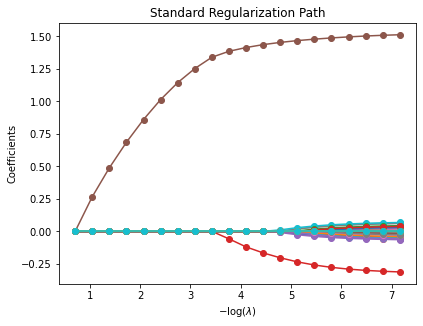

In [4]:
# Example adapted from:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html

# Use standard logistic regression model from scikit-learn
clf = linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-8,
    max_iter=int(1e3),
    warm_start=True)

# Define regularization strengths
cs = l1_min_c(X, y, loss="log") * np.logspace(0, 2.8, 20)

# Loop over regularization strengths and fit model
coefs_reg_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_reg_.append(clf.coef_.ravel().copy())

# Plot regularization path, i.e. coefficients as a function of
# regularization strength
plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.plot(-np.log(1/(n*cs)), np.array(coefs_reg_), marker="o")
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Coefficients")
plt.title("Standard Regularization Path")
plt.axis("tight")
plt.savefig("README_files/README_0.png")


<p align="center">
  <img src="https://github.com/pbenner/pyleapfrog/raw/master/README_files/README_0.png" title="Standard Regulariztion Path">
</p>

### Logistic Regression with Leapfrog Regularization

The advantage of Leapfrog regularization is that we do not need to find a reasonable range of regularization strengths. Instead, we simply specify the number of non-zero parameters we want to estimate. The following code demonstrates how to use *PyTorch* and *PyLeapfrog* to compute a leapfrog regularization path by selecting *q=[0,1,2,60]* features.

First, we define an equivalent logistic regression model:

In [23]:
# Definition of a simple logistic regression model, where
# the weights are subject to leapfrog regularization
class LogisticModel(torch.nn.Module):
    def __init__(self, p, q, weight_decay=None):
        super(LogisticModel, self).__init__()
        # The Leapfrog linear layer is identical to the Torch
        # linear layer, except that the weights are subject to
        # leapfrog regularization
        self.linear = lf.Linear(p, 1, q, weight_decay=weight_decay)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

... and we train the model ...

In [24]:
# Specify a list of the number of features we want to estimate
q = [0,1,2,60]

# Define a simple logistic regression model
model = LogisticModel(X.shape[1], q)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.05)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 500
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_     = []
# Record the loss
loss_  = []
# Record the coefficients of the logistic regression
coefs_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      # print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs_.append(list(model.parameters())[0][0].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break


Training process has finished for target q=0.
Training process has finished for target q=1.
Training process has finished for target q=2.
Training process has finished for target q=60.


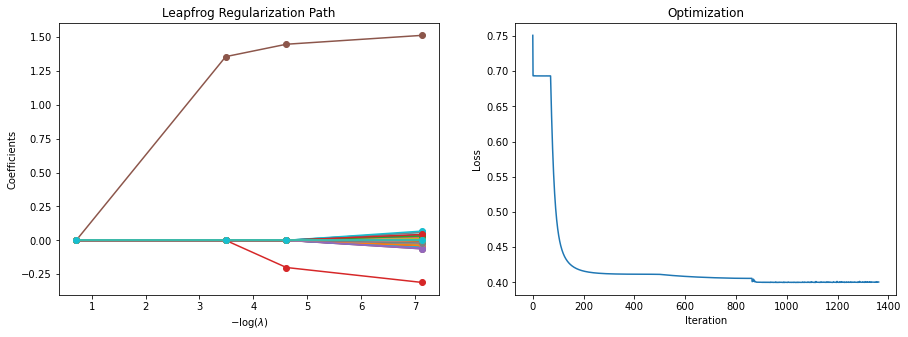

In [26]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(-np.log(l_), np.array(coefs_), marker="o")
ax1.set_xlabel(r"$-\log(\lambda)$")
ax1.set_ylabel("Coefficients")
ax1.set_title("Leapfrog Regularization Path")
ax1.axis("tight")
ax2.plot(np.array(loss_), marker="")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Optimization")
ax2.axis("tight")
plt.savefig("README_files/README_1.png")

<p align="center">
  <img src="https://github.com/pbenner/pyleapfrog/raw/master/README_files/README_1.png" title="Standard Regulariztion Path">
</p>

The regularization path is similar to the standard regularization path, except that it is estimated only at specific positions (*q=[0,1,2,60]*), as shown by the dots. It allows to leapfrog over solutions that are not of interest, i.e. all solutions with 3-59 selected features.

### Two-layer neural network with Leapfrog Regularization
Leapfrog regularization can also be used for more complex models. We demonstrate leapfrog regularization on a two-layer neural network. However, as opposed to logistic regression, the optimization problem for a fixed regularization strength is not convex. As a result, we will get different solutions when we vary the initial conditions or the order in which we estimate parameters (i.e. the order of *q*). Furthermore, the loss can increase during training, because the leapfrog algorithm increases the regularization strength.

In [5]:
# Define a simple two-layer neural network for generating the labels y.
# The first layer has two output neurons, each with two non-zero weights.
# Our goal is to estimate the sparse weight structure of this layer
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def activation(x):
    return torch.nn.LeakyReLU()(torch.tensor(x)).numpy()
def generate_data():
    rng = np.random.RandomState(0)
    # Generate data X from a standard normal distribution
    X  = rng.multivariate_normal(np.zeros(p), np.identity(p), n)
    # Push the generated data through a neural network
    t1 = activation( 1.1*X[:,5] - 0.8*X[:,6])
    t2 = activation( 1.4*X[:,7] - 1.3*X[:,8])
    t3 = sigmoid   ( 1.2*t1     + 1.3*t2     - 1.2)
    # Convert output to binary labels
    y  = t3 > 0.5
    return X, y

In [9]:
# Number of samples
n = 10000
# Number of features
p = 10
# Generate features X and labels y
X, y = generate_data()

In [10]:
class TwoLayerModel(torch.nn.Module):
    def __init__(self, p, q, k, weight_decay=None):
        super(TwoLayerModel, self).__init__()
        # First layer is subject to leapfrog regularization
        self.linear1 = lf.Linear(p, k, q, weight_decay=weight_decay)
        # Second layer is dense
        self.linear2 = torch.nn.Linear(k, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Specify a list of the number of features we want to estimate. We typically obtain
# better solutions if models with more parameters are estimated first.
q = [10,5,4,3,2,1,0]

# Define a simple logistic regression model
model = TwoLayerModel(X.shape[1], q, 2)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.005)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 10000
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_      = []
# Record the loss
loss_   = []
# Record the coefficients of the logistic regression
coefs1_ = []
coefs2_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      #print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs1_.append(list(model.parameters())[0][0].detach().numpy().copy())
      coefs2_.append(list(model.parameters())[0][1].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break

Training process has finished for target q=10.
Training process has finished for target q=5.
Training process has finished for target q=4.
Training process has finished for target q=3.
Training process has finished for target q=2.
Training process has finished for target q=1.
Training process has finished for target q=0.


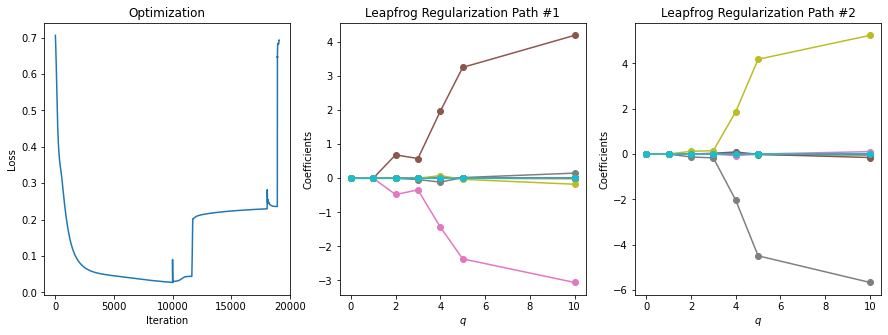

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(np.array(q)[np.array(q) != None], np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$q$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(np.array(q)[np.array(q) != None], np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$q$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.savefig("README_files/README_2.png")

<p align="center">
  <img src="https://github.com/pbenner/pyleapfrog/raw/master/README_files/README_2.png" title="Standard Regulariztion Path">
</p>

The result shows that the algorithm identifies the correct parameters for *q=2*. Furthermore, the loss increases after approximately 10000 iterations, because models with fewer parameters are trained.

/tmp/ipykernel_174116/2333193903.py:8: RuntimeWarning: divide by zero encountered in log
  ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
/tmp/ipykernel_174116/2333193903.py:13: RuntimeWarning: divide by zero encountered in log
  ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")


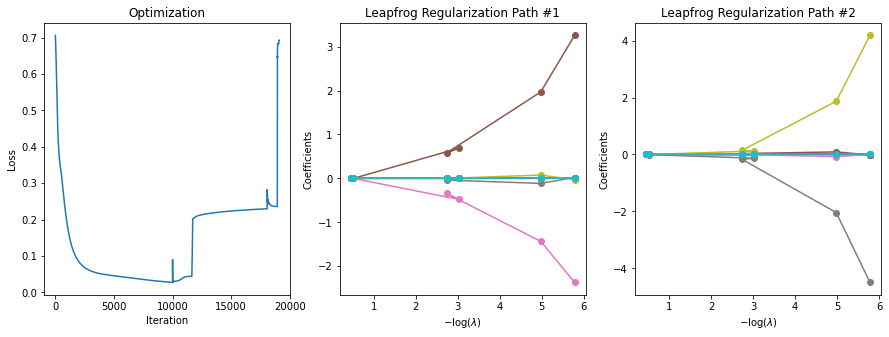

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$-\log(\lambda)$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$-\log(\lambda)$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.savefig("README_files/README_3.png")

<p align="center">
  <img src="https://github.com/pbenner/pyleapfrog/raw/master/README_files/README_3.png" title="Standard Regulariztion Path">
</p>

The result shows the regularization paths as a function of regularization strength. The paths are not simple functions of the regularization strength, since we are dealing with non-convex optimization problems.